코드 생성

In [1939]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from mpl_toolkits.mplot3d import Axes3D
from collections import deque  
import random as rand

sats = [(1, 5), (2, 6), (3, 7), (4, 8), (0, 8), (1, 9), (0, 7), (1, 8), (2, 9), (1, 2),
            (2, 3), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (0, 3), (1, 4), (2, 5), (3, 6),
            (4, 7), (5, 8), (0, 2), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9), (0, 5), (1, 6),
            (2, 7), (3, 8), (4, 9), (3, 9), (0, 6), (1, 7), (3, 9)]
g1tap = [2,9]
g2tap = [1,2,5,7,8,9]
# -5000, -4500, -4000, -3500, -3000, -2500, -2000, -1500, -1000, -500, 0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000
def getCode(satsNum):
    
    g1 = deque(1 for i in range(10))
    g2 = deque(1 for i in range(10))
     
    # result
    g = []
    
    # Generating 1023 chips(One C/A sequence)
    for i in range(1023):
        val = (g1[9] + g2[satsNum[0]] + g2[satsNum[1]]) % 2
        g.append(val)
        
        #shift g1
        g1[9] = sum(g1[i] for i in g1tap) % 2
        g1.rotate()
        
        #shift g2
        g2[9] = sum(g2[i] for i in g2tap) % 2
        g2.rotate()
    # 0 => -1
    for n,i in enumerate(g):
            if i==0:
                g[n]=-1
        
    return g

# 코드 미리 만들어두기(시간복잡도 줄이려고)
codes = []
for i in range(37):
    codes.append(getCode(sats[i]))

In [1940]:
OV = 10
ms = 100 # message 한 bit 마다 20ms #원래는 2초 봐야해서 2000



# C/A code Frequency : 1.023MHz
# IF Frequency : 9.548MHz
# Sampling rate : 38.192MHz
# OV should be 4.
# 알아낸 곳: Kai Borre의 A Software-Defined GPS and Galileo Receiver에서의 p.55(pdf 상으로는 70페이지)
# 이것들 적용해야 하는데, 아직 할 줄 모른다...

Noise 생성

In [1941]:
# 잡음의 전력 비 설정 (잡음은 전력 1, 신호전력은 1/6.31 이런 식으로 만들기)
noise_power = 6.31 # For -8dB. If -22dB, set noise_power to 158.49

# 잡음의 크기 설정
num_samples = 1023 * ms * OV

# 실수부와 허수부에 대한 잡음 생성
real_noise = np.random.normal(0, 1, num_samples) / (np.sqrt(2) * np.sqrt(OV))
imaginary_noise = np.random.normal(0, 1, num_samples) / (np.sqrt(2) * np.sqrt(OV))

# 복소수로 변환
complex_noise = (real_noise + 1j * imaginary_noise) 

# 신호가 쓸 거
sigma = np.sqrt(noise_power)

Data 생성

In [1963]:
data = []
"""
for i in range(ms//20):
    data.append((-1)**i)
"""
RN = rand.randint(0,36)
t_code = codes[RN]
t_code = [chip/(sigma*np.sqrt(OV)) for chip in t_code for _ in range(OV)]
t_code_inv = [x*-1 for x in t_code]
seq = []

#data = [1,1,1,1,1]
#data = [1,-1,1,-1,1]
#data = [1,1,1,-1,-1]
data = [1,-1,1,1,-1]

for d in data:
    if d == 1:
        seq.extend(t_code*20)
    else:
        seq.extend(t_code_inv*20)
        

cor_data = []
for value in data:
    cor_data.extend([value] * 20)


Signal 생성

In [1964]:
def generate_transmitted_signal(code_delay, doppler_freq, svNumber, code_freq, signal_length, OV = 1.023e6*OV):
    # delayed_seq = np.roll(seq, code_delay) # code_delay : delay된 sample 수
    t = np.arange(signal_length)
    code_phase = 2 * np.pi * code_freq * t / OV
    ct = np.cos(code_phase) * seq
    oversampled_signal = np.cos(code_phase) * np.exp(1j * (2 * np.pi * doppler_freq * t / OV))
    #oversampled_signal = np.exp(1j*(2*np.pi * (code_freq + doppler_freq) * t / OV))
    signal = ct * oversampled_signal[:signal_length] + complex_noise
    delayed_signal = np.roll(signal, code_delay)
    return delayed_signal

Replica 신호 생성

In [1965]:
def generate_replica_signal(code_delay, doppler_freq, code_freq, svNumber, signal_length = 1023*OV ,OV = 1.023e6*OV ):
    ca_code = np.array(codes[svNumber])
    ca_code = [chip for chip in ca_code for _ in range(int(OV//1.023e6))]
    # delayed_code = np.roll(ca_code, code_delay)
    
    t = np.arange(signal_length)
    code_phase = 2 * np.pi * code_freq * t / OV
    ct = np.cos(code_phase) * ca_code
    oversampled_signal = np.cos(code_phase) * np.exp(1j * (2 * np.pi * (doppler_freq) * t / OV))
    #oversampled_signal = np.exp(1j*(2*np.pi * (code_freq + doppler_freq) * t / OV))
    replica =  ct * oversampled_signal[:signal_length]
    delayed_replica = np.roll(replica, code_delay)
    return delayed_replica
    

Acquisition

In [1966]:
def acquisition(signal, code_delay_range, doppler_freq_range,code_freq, svNumber, signal_length, OV):
    
    # 신호 1ms씩 쪼개기
    signal_div = [signal[i:i+(1023*OV)] for i in range(0,len(signal), 1023*OV)]
    
    # 1ms 안에서 F(code 혹은 frame delay & 주파수 offset 찾기)
    max_corr = 0
    max_code_delay = 0
    max_doppler_freq = 0
    corr_matrix = np.zeros((len(code_delay_range), len(doppler_freq_range)))
    
    Fsignal = signal_div[0] 
    for i, doppler_freq in enumerate(doppler_freq_range):
        replica = generate_replica_signal(code_delay_range[0],doppler_freq,code_freq, svNumber)
        
        for j, code_delay in enumerate(code_delay_range):
            
            cor = np.abs(correlate(Fsignal, replica, mode='valid'))
            peak = np.max(cor)
            corr_matrix[j, i] = peak
            
            if peak > max_corr:
                max_corr = peak
                max_code_delay = code_delay
                max_doppler_freq = doppler_freq
            replica = np.roll(replica, (OV if OV == 1 else OV//2)) # sampling 안 했을 경우 1씩, 했으면 0.5 chip씩 이동
            
    print('-'*40)
    print('Frame Sync completed.')
    print('Frame delay :', max_code_delay/OV)
    print('Estimated_Frequency Offset :', max_doppler_freq)
    print('Max correlation :', max_corr)
    print('-'*40)
    
    ##############
    # 20ms 안에서 bit boundary(B) 값 탐색
    True_replica = generate_replica_signal(max_code_delay, max_doppler_freq, code_freq, svNumber)
    cor_lst = []
    phase  = []
    for i in range(ms):
        cor = correlate(signal_div[i], True_replica, mode = 'valid')
        cor_lst.append(np.max(cor)) #cor_lst 얘로 phase 계산
        phase.append(np.arctan2(np.imag(cor), np.real(cor))) #왜 arctan2를 썼을까
    print(*phase)
    phase_diff = []
    for i in range(1, ms):
        """
        #1
        if phase[i-1] <= -(np.pi)/2 and phase[i] >= (np.pi)/2:
            phase_diff.append(2*np.pi + (phase[i]- phase[i-1]))
        elif phase[i-1] >= np.pi/2 and phase[i] <= -np.pi/2:
            phase_diff.append(2*np.pi - (phase[i]- phase[i-1]))
        else:
            phase_diff.append(phase[i]-phase[i-1])"""
        """
        #2
        if np.real(phase[i])<0 and np.imag(phase[i])>0 and np.real(phase[i-1])<0 and np.imag(phase[i-1])<0:
            phase_diff.append((2*np.pi-(phase[i]-phase[i-1]))) #360도 - 차이
        else:
            phase_diff.append(((phase[i]-phase[i-1]))) 
        """
        phase_diff.append(cor_lst[i] * np.conj(cor_lst[i-1]))
        
    print(*phase_diff)  
    mean_phasediff = sum(phase_diff)/ms
    
    
    return max_code_delay, max_doppler_freq, cor_lst, phase, phase_diff, corr_matrix
    
    
    
    
            

Acquisition 실행

In [1967]:
#bit boundary 찾아야 한다
#노이즈 좀더 크게


# Parameters
####### B = rand.randint(0,20)  # Bit Boundary 무작위 설정 - bit boundary - 1ms안에서 맞추는거 (frame 동기화도 있음)
# F = rand.randint(0,1023) # 1ms code 내 delay 설정


code_delay_range = np.arange(0, 1023*OV, (OV if OV == 1 else OV//2))    # 단순히 F를 찾기 위한 범위 #늘려놓음-그래야 bit  boundary 찾는 의미 생기니까
doppler_freq_range = np.linspace(-5000, 5000, 21)  # Adjusted range of Doppler frequency in Hz
code_freq = 1.023e6  # Code frequency in Hz
svNumber = RN

# Generate received signal
#true_code_delay = rand.randint(0, (20*1023)*OV) # Range of code delay in chips (0 ~ 1023*19 + F)
true_code_delay = 1023*4*OV+23

#true_doppler_freq = rand.randint(-5000,5000)
#true_doppler_freq = rand.sample(range(-5000, 5000, 500), 1)[0]
true_doppler_freq = 3859


received_signal = generate_transmitted_signal(true_code_delay, true_doppler_freq, svNumber, code_freq, 1023*20*(ms//20)*OV)

# Perform acquisition
estimated_code_delay, estimated_doppler_freq, cor_lst_x, phase, phase_diff, corr_matrix = acquisition(received_signal, code_delay_range, doppler_freq_range, code_freq, svNumber,1023*20*(ms//20)*OV,OV)

print()
print("-"*18,'Test','-'*18)
print("Target SV Number:", svNumber + 1)
print("True Code Delay:", true_code_delay/OV) #frame delay?
print("True doppler frequency:", true_doppler_freq)
print('-'*40)
print("B :", true_code_delay//(OV*1023))
B = true_code_delay//(OV*1023)


----------------------------------------
Frame Sync completed.
Frame delay : 2.0
Estimated_Frequency Offset : 4000.0
Max correlation : 138.49985709770817
----------------------------------------
[-0.8099711] [-1.56488826] [-2.50569491] [3.13331096] [-0.4636191] [-1.42837797] [-2.22075394] [3.1158519] [2.238267] [1.33845968] [0.58596361] [-0.57526586] [-1.19685274] [-2.16295309] [-3.04021204] [2.24124551] [1.55082198] [0.74684632] [-0.21315258] [-1.18635751] [-2.19641842] [-2.98941842] [2.55205632] [1.56779887] [-2.48263202] [2.9331706] [1.93563154] [1.25388264] [0.27052984] [-0.5947576] [-1.42331163] [-2.34191317] [2.84571933] [2.05502086] [1.27009211] [0.47160486] [-0.39097366] [-1.59628145] [-2.16956477] [-3.11704086] [2.24355021] [1.37154364] [0.34170078] [-0.43219858] [1.74651644] [0.97056256] [0.01528259] [-0.85538364] [-1.77604427] [-2.5794003] [2.80162513] [1.98237562] [1.03922819] [0.04109441] [-0.70134224] [-1.78035476] [-2.54827546] [2.76276087] [2.07939519] [1.20027113] [0.0

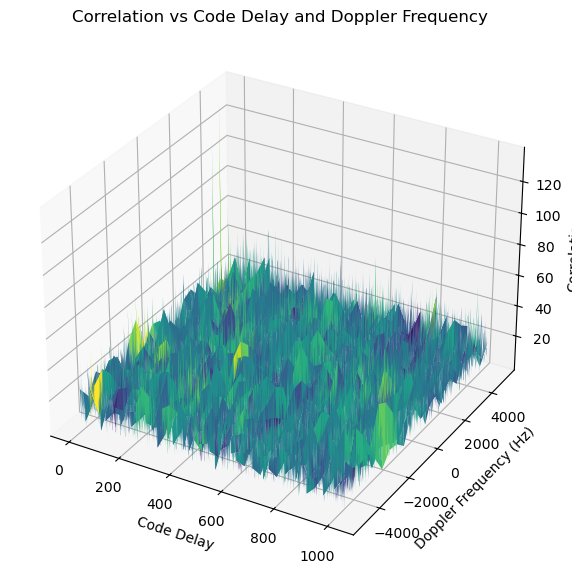

In [1968]:
# Plotting
Code_Delay, Doppler_Freq = np.meshgrid(code_delay_range//OV, doppler_freq_range)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Code_Delay, Doppler_Freq, corr_matrix.T, cmap='viridis')
ax.set_xlabel('Code Delay')
ax.set_ylabel('Doppler Frequency (Hz)')
ax.set_zlabel('Correlation')
ax.set_title('Correlation vs Code Delay and Doppler Frequency')
plt.show()



In [1969]:
"""
t = np.arange(len(received_signal))
# 복소수 값을 극 좌표 형태로 변환
amplitude = np.abs(received_signal)
phase = np.angle(received_signal)

# 벡터화된 함수를 사용하여 각 요소에 대해 계산 수행
exp_phase = np.vectorize(cmath.exp)(1j * phase)
exp_freq = np.vectorize(cmath.exp)(-1j * (((2*np.pi*(estimated_doppler_freq)*t) +2*np.pi*(estimated_doppler_freq*estimated_code_delay))/ OV))


# 극 좌표 형태로 변환된 복소수 값을 cmath.exp()에 전달하여 지수 함수 계산
received_signal = amplitude * exp_phase * exp_freq
"""

# 시간 배열 생성
t = np.arange(len(received_signal))
# 주파수에 대한 phase offset 계산
phase_offset_freq = 2 * np.pi * estimated_doppler_freq * t
# 코드 딜레이에 대한 phase offset 계산
phase_offset_delay = -2 * np.pi * estimated_code_delay
# 총 phase offset 계산
total_phase_offset = phase_offset_freq + phase_offset_delay




# 복소수 값을 극 좌표 형태로 변환
amplitude = np.abs(received_signal)
phase = np.angle(received_signal)
# 총 phase offset을 보상하여 새로운 phase 계산
new_phase = phase + total_phase_offset
# 극 좌표 형태로 변환된 복소수 값을 cmath.exp()에 전달하여 지수 함수 계산
received_signal = amplitude * np.exp(1j * new_phase)

print(phase)
print(new_phase)

[-1.41198816  0.3709713  -2.63905785 ... -0.67545094  2.21429126
  1.55637612]
[-1.27075694e+02  2.50074485e+04  5.01371797e+04 ...  2.57107188e+10
  2.57107439e+10  2.57107690e+10]


In [1970]:

# 신호 1ms씩 쪼개기
signal_div = [received_signal[i:i+(1023*OV)] for i in range(0,len(received_signal), 1023*OV)]

##############
# 20ms 안에서 bit boundary(B) 값 탐색
cor_lst = []
True_replica = generate_replica_signal(estimated_code_delay, estimated_doppler_freq, code_freq, svNumber)
phase  = []
for i in range(ms): #100번 반복
    cor = correlate(signal_div[i], True_replica, mode = 'valid')
    cor_lst.append(np.max(cor)) #cor_lst 얘로 phase 계산
    phase.append(np.arctan2(np.imag(cor), np.real(cor))) #왜 arctan2를 썼을까


phase_diff = []
for i in range(1, ms):
    phase_diff.append((cor_lst[i] * np.conj(cor_lst[i-1])))
    


Index 0: -43.25356695263158
Index 1: -53.90425524340455
Index 2: -36.90876421127714
Index 3: 153.91109154457544
Index 4: -55.27661097175482
Index 5: -45.39980114843769
Index 6: -54.23500949615498
Index 7: -50.28192458309257
Index 8: -51.55516529482889
Index 9: -43.11484799175175
Index 10: -66.53355151291001
Index 11: -35.61430609765545
Index 12: -55.35347551925463
Index 13: -50.263233408683895
Index 14: -57.39477767523961
Index 15: -39.55834816027783
Index 16: -46.06438847682023
Index 17: -55.00389221747495
Index 18: -55.760538716981415
Index 19: -57.87222560514804
Index 20: -45.43555197977274
Index 21: -42.49688914929738
Index 22: -56.393803602652554
Index 23: 127.92740954136129
Index 24: -49.697371493343596
Index 25: -57.15477418129917
Index 26: -39.0613414805647
Index 27: -56.34196298496107
Index 28: -49.577322164875355
Index 29: -47.472652156503116
Index 30: -52.63198954542184
Index 31: -62.7705568034983
Index 32: -45.303679282828405
Index 33: -44.973111921821406
Index 34: -45.7499

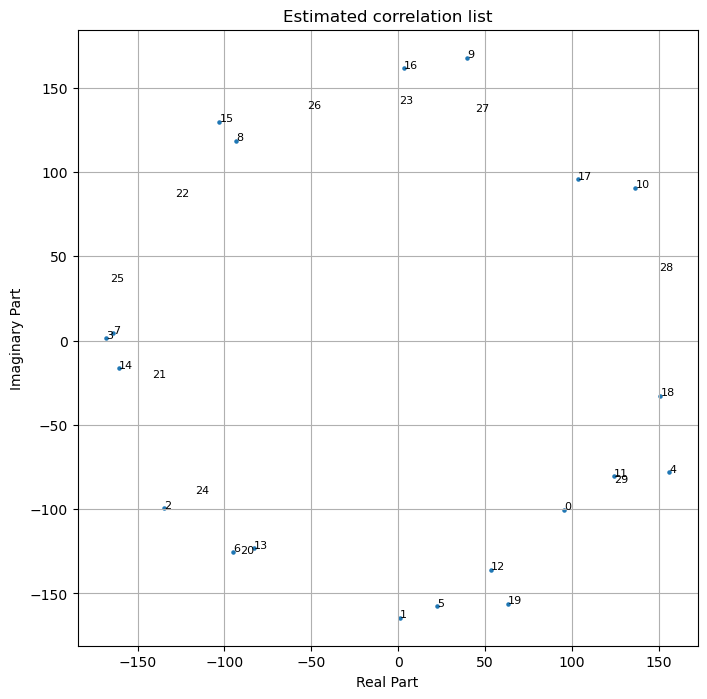

In [1972]:
degree_list = [np.degrees(np.angle(value)) for value in phase_diff]

for idx, value in enumerate(degree_list):
    print(f"Index {idx}: {value}")

plt.figure(figsize=(8, 8))
plt.scatter(np.real(cor_lst[:20]), np.imag(cor_lst[:20]), s=5)

for i, txt in enumerate(range(0, 0 + 30)):
    plt.annotate(f'{txt}', (np.real(cor_lst[i]), np.imag(cor_lst[i])), fontsize = 8)
    
plt.title("Estimated correlation list")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True)
plt.show()

# 주파수 offset = 0일 때 1~20번은 오른쪽, 21~39번이 왼쪽에 있다면 bit boundary 잘 찾은거.(부호반전)
# 위아래로 돌아간 거는 noise에 의한 영향 + 약간의 주파수 offset과 code delay에 관한 거.

In [1973]:

"""print(degree_list)
for i in range(len(degree_list)):
    if degree_list[i]<0:
        degree_list[i] = 360+degree_list[i]



#나중에 20개씩 슬라이딩하면서 튀는값을 찾아야함 - 찾으면 그거의 인덱스 반환

# 차이가 다른 값들과 많이 나는 값을 찾는 함수
def find_outlier(cor_lst):
    # 교차 상관 값들 사이의 차이를 저장할 변수 초기화
    max_difference = 0
    outlier_value = None
    outlier_index = None
    
    # 각 값들 사이의 차이를 계산하여 가장 큰 차이를 갖는 값을 찾음
    for i in range(len(cor_lst) - 1):
        difference = abs(cor_lst[i] - cor_lst[i + 1])
        if difference > max_difference:
            max_difference = difference
            outlier_value = cor_lst[i] if cor_lst[i] > cor_lst[i + 1] else cor_lst[i + 1]
            outlier_index = i if cor_lst[i] > cor_lst[i + 1] else i + 1
    
    return outlier_value, outlier_index

# 차이가 다른 값들과 많이 나는 값을 찾음
outlier_value, outlier_index = find_outlier(degree_list[:40])
print("Outlier Value:", outlier_value)
print("Outlier Index:", outlier_index)


print(B)
print(cor_lst)
"""

print(degree_list)
"""
for i in range(len(degree_list)):
    if degree_list[i]<0:
        degree_list[i] = 360+degree_list[i]
"""

#나중에 20개씩 슬라이딩하면서 튀는값을 찾아야함 - 찾으면 그거의 인덱스 반환

# 차이가 다른 값들과 많이 나는 값을 찾는 함수
def find_outlier(cor_lst):
    # 교차 상관 값들 사이의 차이를 저장할 변수 초기화
    max_difference = 0
    outlier_value = None
    outlier_index = None
    
    # 각 값들 사이의 차이를 계산하여 가장 큰 차이를 갖는 값을 찾음
    for i in range(len(cor_lst) - 1):
        difference = abs(cor_lst[i] - cor_lst[i + 1])
        if difference > max_difference:
            max_difference = difference
            outlier_value = cor_lst[i] if cor_lst[i] > cor_lst[i + 1] else cor_lst[i + 1]
            outlier_index = i if cor_lst[i] > cor_lst[i + 1] else i + 1
    
    return outlier_value, outlier_index

# 차이가 다른 값들과 많이 나는 값을 찾음
outlier_value, outlier_index = find_outlier(degree_list[:40])
print("Outlier Value:", outlier_value)
if outlier_index>20:
    print("Outlier Index:", outlier_index-20)
else:
    print("Outlier Index:", outlier_index)


print(B)
print(cor_lst)

[-43.25356695263158, -53.90425524340455, -36.90876421127714, 153.91109154457544, -55.27661097175482, -45.39980114843769, -54.23500949615498, -50.28192458309257, -51.55516529482889, -43.11484799175175, -66.53355151291001, -35.61430609765545, -55.35347551925463, -50.263233408683895, -57.39477767523961, -39.55834816027783, -46.06438847682023, -55.00389221747495, -55.760538716981415, -57.87222560514804, -45.43555197977274, -42.49688914929738, -56.393803602652554, 127.92740954136129, -49.697371493343596, -57.15477418129917, -39.0613414805647, -56.34196298496107, -49.577322164875355, -47.472652156503116, -52.63198954542184, -62.7705568034983, -45.303679282828405, -44.973111921821406, -45.74995322395278, -49.422115099357164, -69.05904526858147, -32.84671370282022, -54.286384207386185, -52.86075144178327, -49.962301949361944, -59.00564905154864, -44.341169289681815, 124.83118127196175, -44.458900915523714, -54.73350461884925, -49.88549710492184, -52.74997444323256, -46.028912948518126, -51.689

In [1974]:
degree_list  = degree_list[B:] + degree_list[:B] #B 안돼


In [1975]:
print(degree_list[18])
print(degree_list[19])

print(degree_list[38])
print(degree_list[39])

print(degree_list[58])
print(degree_list[59])

print(degree_list[78])
print(degree_list[79])

-56.393803602652554
127.92740954136129
-44.341169289681815
124.83118127196175
-41.47271545053611
-48.12958842108532
-48.86686335300569
123.557600920806


 ### *frequency, delay 고정 하고 돌림* (임의의 doppler freq, delay 고정)
 ### *code delay도 잘 못잡아서 그냥 B값 정확히 계산했다고 가정하고 계산*
 

* B 정확히 찾지 못하면 demodulation하지 못한다 (1차이도 X)
* boundary 어떻게 잡아야 할지
* 진짜 아닌것같은데 이거 (특정 doppler freq, delay일때 + B를 정확히 잡았다고 할 때 잘 돌아가도록 만들어 놓은거)

In [1976]:
import cmath
cor_lst = cor_lst[B:] + cor_lst[:B]
phase_diff  = phase_diff[B:] + phase_diff[:B]

cor_lst_1 = cor_lst[:20]
cor_lst_2 = cor_lst[20:40] 
cor_lst_3 = cor_lst[40:60]
cor_lst_4 = cor_lst[60:80]
cor_lst_5 = cor_lst[80:100]

new_s_1 = [0] * (len(cor_lst_1))  # cor_lst의 길이보다 하나 작은 크기의 빈 리스트 생성

cumulative_phase = 0 #맨 첫번째건 여기서 계산
new_s_1[0] = cor_lst_1[0]
for i in range(len(cor_lst_1[1:])): #0~18까지  
    cumulative_phase += cmath.phase(phase_diff[i]) #phase diff는 무조건 0부터 18
    new_s_1[i+1] = cor_lst_1[i+1] * cmath.exp(-1j * cumulative_phase)

print(len(new_s_1),new_s_1)





if abs(degree_list[18]-degree_list[19]) >150: #boundary 설정
    cumulative_phase += np.pi
    print("bit change")
    
new_s_2 = [0] * (len(cor_lst_2))  # cor_lst의 길이보다 하나 작은 크기의 빈 리스트 생성

#cumulative_phase = 0
#cumulative_phase += np.pi
for i in range(len(cor_lst_2)):
    cumulative_phase += cmath.phase(phase_diff[19+i]) #19부터 
    new_s_2[i] = cor_lst_2[i] * cmath.exp(-1j * cumulative_phase)

print(len(new_s_2),new_s_2)






if abs(degree_list[38]-degree_list[39]) >150: #boundary 설정
    cumulative_phase += np.pi
    print("bit change")



new_s_3 = [0] * (len(cor_lst_3))  # cor_lst의 길이보다 하나 작은 크기의 빈 리스트 생성

#cumulative_phase = 0
#cumulative_phase += np.pi
for i in range(len(cor_lst_3)):
    cumulative_phase += cmath.phase(phase_diff[39+i])
    new_s_3[i] = cor_lst_3[i] * cmath.exp(-1j * cumulative_phase)

print(len(new_s_3),new_s_3)





if abs(degree_list[58]-degree_list[59]) >150: #boundary 설정
    print("bit change")
    cumulative_phase += np.pi


new_s_4 = [0] * (len(cor_lst_4))  # cor_lst의 길이보다 하나 작은 크기의 빈 리스트 생성

#cumulative_phase = 0
#cumulative_phase += np.pi/2
for i in range(len(cor_lst_4)):
    cumulative_phase += cmath.phase(phase_diff[59+i])
    new_s_4[i] = cor_lst_4[i] * cmath.exp(-1j * cumulative_phase)

print(len(new_s_4),new_s_4)




if abs(degree_list[78]-degree_list[79]) >150: #boundary 설정
    print("bit change")
    cumulative_phase += np.pi


new_s_5 = [0] * (len(cor_lst_5))  # cor_lst의 길이보다 하나 작은 크기의 빈 리스트 생성

#cumulative_phase = 0
#cumulative_phase += np.pi/2
for i in range(0,len(cor_lst_5)):
    cumulative_phase += cmath.phase(phase_diff[79+i])
    new_s_5[i] = cor_lst_5[i] * cmath.exp(-1j * cumulative_phase)

print(len(new_s_5),new_s_5)


20 [(156.17620091664446-78.08254833493979j), (142.51505705068118-71.25246206082193j), (140.65578097384557-70.32289012037631j), (146.66709342632308-73.32833264216951j), (135.0044690219376-67.49743505071308j), (154.18454138573406-77.08678937373894j), (146.740423111431-73.36499487782534j), (132.51936080084678-66.25496928671087j), (130.5477874068854-65.26925267991471j), (132.75068381528817-66.3706225703103j), (144.66678459563232-72.32824933856428j), (148.0456924022497-74.0175831204146j), (144.51382964050788-72.25177729860906j), (126.11268001522633-63.051856653840815j), (138.22363868994367-69.10690544200912j), (150.67915767973946-75.33422213846637j), (139.00978847978152-69.49995238900374j), (128.0999243236123-64.04540816074214j), (137.99989668874733-68.99504239552425j), (125.67329401262698-62.83217927288075j)]
bit change
20 [(-132.3433757904459+66.16698303784437j), (-151.3983512512365+75.69379335660982j), (-131.62591474198373+65.80827801962653j), (-128.07161841858175+64.03125621451252j), (-

[1, -1, 1, 1, -1]


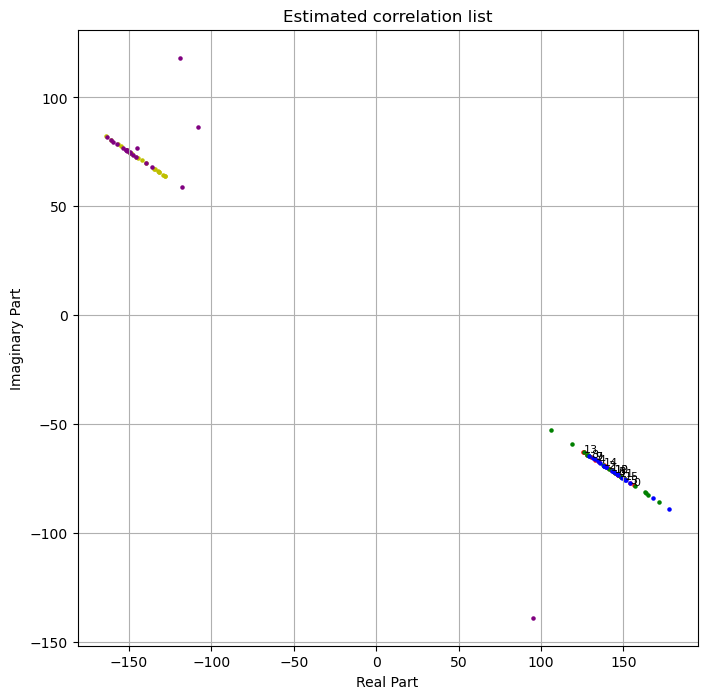

In [1977]:
print(data)

plt.figure(figsize=(8, 8))
plt.scatter(np.real(new_s_1), np.imag(new_s_1), s=5, label='New_s_1', c='r')
plt.scatter(np.real(new_s_2), np.imag(new_s_2), s=5, label='New_s_2', c='y')
plt.scatter(np.real(new_s_3), np.imag(new_s_3), s=5, label='New_s_3', c='g')
plt.scatter(np.real(new_s_4), np.imag(new_s_4), s=5, label='New_s_4', c='b')
plt.scatter(np.real(new_s_5), np.imag(new_s_5), s=5, label='New_s_5', c='purple')


for i, txt in enumerate(range(0, 16)):
    plt.annotate(f'{txt}', (np.real(new_s_1[i]), np.imag(new_s_1[i])), fontsize = 8)
    
plt.title("Estimated correlation list")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True)
plt.show()


## 밑에는

## 작업중

## 병렬구조 만들기 (Demod, DLL 하기 전)

신호를 I, Q로 쪼갠 뒤 각각을 계산해야함

In [1978]:
# Extract real and imaginary parts separately
def spliter(signal):
    return np.real(signal), np.imag(signal)

real_part, imaginary_part = spliter(received_signal)

cur_code_delay = estimated_code_delay

E = generate_replica_signal(cur_code_delay - (OV // 2), estimated_doppler_freq, code_freq, svNumber)
P = generate_replica_signal(cur_code_delay, estimated_doppler_freq, code_freq, svNumber)
L = generate_replica_signal(cur_code_delay + (OV // 2), estimated_doppler_freq, code_freq, svNumber)

Real_E, Imag_E = spliter(E)
Real_P, Imag_P = spliter(P)
Real_L, Imag_L = spliter(L)

signal_div_Real = [real_part[i:i+(1023*OV)] for i in range(0,len(real_part), 1023*OV)]
signal_div_Imaginary = [imaginary_part[i:i+(1023*OV)] for i in range(0,len(imaginary_part), 1023*OV)]

def I_and_D(signal, replica):
    correlation = []
    for lst in signal:
        cor = correlate(lst, replica,mode='valid')
        correlation.append(np.max(cor))
    return list(correlation)

I_E = I_and_D(signal_div_Real, Real_E)
Q_E = I_and_D(signal_div_Imaginary, Imag_E)
I_P = I_and_D(signal_div_Real, Real_P)
Q_P = I_and_D(signal_div_Imaginary, Imag_P)
I_L = I_and_D(signal_div_Real, Real_L)
Q_L = I_and_D(signal_div_Imaginary, Imag_L)


print(I_E)
print(Q_E)
print(I_P)
print(Q_P)
print(I_L)
print(Q_L)

[31.724156720562178, -4.8277669181689244, -29.091930322219063, -30.8958667879728, 14.517704491615568, 5.163390547003413, -14.525864044731788, -40.9177183945948, -15.992802031312687, 21.664701594237084, 48.67944446217864, 39.901089879781466, 7.0924569933191215, -18.891264324976135, -41.81534755693113, -16.680830007502674, 17.062463793282955, 36.20725379380115, 28.538828182509718, 15.73971605584391, -25.374590488244696, -37.05902897539017, -17.695112757265118, 11.65425537370504, -40.30409796205304, -22.969067460385276, -4.381646827451254, 8.466735229362289, 49.782885045738055, 34.45991949448989, -2.929872181006754, -18.406028913763503, -34.5197902178362, -11.206347549281789, 1.8695866401422734, 15.797176559376965, 45.89371117499892, -5.601931501472777, -25.19913940016162, -24.035636892489205, -8.220713720193345, 10.622339558509214, 42.95326453238182, 29.225402650366206, 1.7614229422309569, 25.291592191798287, 23.290345810224753, 31.78565184520012, -4.589374551868319, -38.79795476769627, 

In [1979]:
#incoming signal 받고
#NCO carrier generator에서 받아와서 sin, cos 곱해
#여기까지  signal * sin, signal * cos


#그거랑 PRN이랑 곱해(E,P,L)
#여기까지 signal*sin*PRN...


# Residual code/carrier phase
remCodePhase = 0.0

# define residual carrier phase
remCarrPhase  = 0.0

# code tracking loop parameters
oldCodeNco   = 0.0
oldCodeError = 0.0

# carrier/Costas loop parameters
oldCarrNco = 0.0
oldCarrError = 0.0

dataPosition = 0
blksize = 0


carrFreq = -3363.8
fs = 1023*OV*1000
codeLength = 1023
earlyLateSpacing = 0.5
chippingRate = 1023000
codeFreq = 1023000







In [1980]:
# 91p
# Calculate filter coefficient values for code loop
def calculate_loop_coefficients(loop_noise_bandwidth, zeta, loop_gain, sum_int):
    """
    Calculates the loop coefficients tau1 and tau2.

    This process is discussed in sections 7.1-7.3 of Borre.

    Parameters:
    loop_noise_bandwidth (float): Loop noise bandwidth.
    zeta (float): Damping ratio.
    loop_gain (float): Loop gain.
    sum_int (float): Summation interval.

    Returns:
    tuple: Coefficient 1 (coeff1) and Coefficient 2 (coeff2).
    """
    # Solve for the natural frequency
    wn = loop_noise_bandwidth * 8 * zeta / (4 * zeta**2 + 1)

    # Solve for tau1 and tau2
    tau1 = loop_gain / (wn * wn)
    tau2 = (2.0 * zeta) / wn

    coeff1 = tau2 / tau1
    coeff2 = float(sum_int) / tau1

    return coeff1, coeff2


#91p참고 (loop_gain, sum_int는 모르겠다)
loop_noise_bandwidth = 20
zeta = 0.7
loop_gain = 1
sum_int = 1e-3
#coeffCode1, coeffCode2 = calculate_loop_coefficients(loop_noise_bandwidth,zeta,loop_gain,sum_int)
#coeffCar1, coeffCar2 = calculate_loop_coefficients(loop_noise_bandwidth,zeta,loop_gain,sum_int)
coeffCode1, coeffCode2 = 5.2972972972972965, 0.014317019722425127
coeffCar1, coeffCar2 = 264.86486486486484, 8.948137326515706

print(coeffCode1, coeffCode2)
print(coeffCar1, coeffCar2)

t_code = [item for item in t_code for _ in range(10)]

5.2972972972972965 0.014317019722425127
264.86486486486484 8.948137326515706


In [1981]:

#Store the shift registers as a deque, so that deque.rotate() can be used.
from collections import deque  
import numpy as np

'''
GPS Gold Code generator. Initialized with the feedback taps for one satellite.
'''

#Feedback taps as defined in GPS spec
g1tap = [2,9]
g2tap = [1,2,5,7,8,9]

sats = [(1, 5), (2, 6), (3, 7), (4, 8), (0, 8), (1, 9), (0, 7), (1, 8), (2, 9), (1, 2),
            (2, 3), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (0, 3), (1, 4), (2, 5), (3, 6),
            (4, 7), (5, 8), (0, 2), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9), (0, 5), (1, 6),
            (2, 7), (3, 8), (4, 9), (3, 9), (0, 6), (1, 7), (3, 9)]


def getCode(num, zero = False, samplesPerChip = 1, prn = 0):
    '''
    Returns a list of bits that form the Gold Code PRN of the designated satellite
    
    zero flag determines whether 0 or -1 is returned
    '''
    g1 = deque(1 for i in range(10))
    g2 = deque(1 for i in range(10))
    
        
    g = []

    for i in range(num):
        val = (g1[9] + g2[prn[0]] + g2[prn[1]]) % 2
        g.append(val)

        #Shift g1
        g1[9] = sum([g1[i] for i in g1tap]) % 2 
        g1.rotate()

        #Shift g2
        g2[9] = sum([g2[i] for i in g2tap]) % 2 
        g2.rotate()

    if(zero == False):
        #format GC to have -1 in place of 0
        for n,i in enumerate(g):
            if i==0:
                g[n]=-1
    
    if (samplesPerChip > 1 ):
        # Repeat each chip to match our ADC sample frequency
        gsamp = np.repeat(g, samplesPerChip)
        return gsamp
    return g

def getTrackingCode(sat):
    '''
    Returns a code ready to be used by Tracking.py
    '''
    code = np.array(getCode(1023, prn = sats[sat - 1]))

    # Need to add extra code chips to the ends so that it can 'slide'
    # back and forth during tracking.
    code = np.append(code,code[0])
    code = np.insert(code,0, code[len(code) - 2])
    return code


def getAcquisitionCode(sat, spc):
    '''
    Returns a code ready to be used by Acquisition.py
    '''
    return getCode(1023, samplesPerChip = spc, prn = sats[sat-1])



## Tracking loop test

In [1982]:

import numpy as np
import matplotlib.pyplot as plt
import configparser



# code tracking loop parameters
oldCodeNco   = 0.0
oldCodeError = 0.0

# carrier/Costas loop parameters
oldCarrNco   = 0.0
oldCarrError = 0.0

acquiredCarrFreq = estimated_doppler_freq
chippingRate = code_freq #codeFreqBasis

dataPosition = 0
CACode = getTrackingCode(RN)

I_P_list = []

# Process the requested number of code periods (num of ms to process)
for i in range(0, ms):
    print("\n------- %2.1f percent complete --------"%((i/ms)*100), end = '\r')
    # Find PLL error and update carrier NCO
    # Implement carrier loop discriminator (phase detector)

    # Update the phasestep based on code freq (variable) and
    # sampling frequency (fixed)
    codePhaseStep = np.real(codeFreq / fs) #맨아래에서 업데이트 시킨 codeFreq여기서 사용-LOOP
    
    
    #print("Old blksize: %d"%blksize)
    blksize = int(np.ceil((codeLength-remCodePhase) / codePhaseStep))
    #print("New blksize: %d"%blksize)
    #print("Old remCodePhase: %f" %remCodePhase)

    # Read in the appropriate number of samples to process this
    # iteration
    rawSignal = received_signal[dataPosition:dataPosition+blksize]
    dataPosition = dataPosition + blksize


    
    # Generate Early CA Code.
    tStart = remCodePhase - earlyLateSpacing
    tStep = codePhaseStep
    tEnd = ((blksize-1)*codePhaseStep+remCodePhase) + codePhaseStep - earlyLateSpacing
    tcode = np.linspace(tStart,tEnd,blksize,endpoint=False)
    tcode2 = (np.ceil(tcode)).astype(int)
    earlyCode = CACode[tcode2]




    # Generate Late CA Code.
    tStart = remCodePhase + earlyLateSpacing
    tStep = codePhaseStep
    tEnd = ((blksize-1)*codePhaseStep+remCodePhase) + codePhaseStep + earlyLateSpacing
    tcode = np.linspace(tStart,tEnd,blksize,endpoint=False)
    tcode2 = (np.ceil(tcode)).astype(int)
    lateCode = CACode[tcode2]


    # Generate Prompt CA Code.
    tStart = remCodePhase
    tStep = codePhaseStep
    tEnd = ((blksize-1)*codePhaseStep+remCodePhase) + codePhaseStep
    tcode = np.linspace(tStart,tEnd,blksize,endpoint=False)
    tcode2 = (np.ceil(tcode)).astype(int)
    promptCode = CACode[tcode2]

    
    
    # Figure out remaining code phase (uses tcode from Prompt CA Code generation):
    remCodePhase = (t_code[blksize-1]) - 1023.00   #t_code: 10230
    if abs(remCodePhase) > codePhaseStep:
        remCodePhase = np.sin(remCodePhase)*codePhaseStep
    else:
        remCodePhase = 0


    # Generate the carrier frequency to mix the signal to baseband
    time = np.array(range(0,blksize+1))/fs
    
    #print("Length of time array for cos and sin: %d" %len(time))
    # Get the argument to sin/cos functions
    trigarg = ((carrFreq * 2.0 * np.pi) * time) + remCarrPhase
    
    # Carry the leftover phase to the next argument by looking at the last element
    #remCarrPhase = trigarg[blksize] % (2 * np.pi)
    remCarrPhase_real = trigarg[blksize-1].real % (2 * np.pi)
    remCarrPhase_imag = trigarg[blksize-1].imag % (2 * np.pi)
    remCarrPhase = remCarrPhase_real + 1j * remCarrPhase_imag


    # Finally compute the signal to mix the collected data to baseband
    carrCos = np.cos(trigarg[0:blksize])
    carrSin = np.sin(trigarg[0:blksize])
    
    # First mix to baseband
    #print(len(carrCos), len(rawSignal))
    qBasebandSignal = carrCos * rawSignal #38192, 30026
    iBasebandSignal = carrSin * rawSignal
    
    # Now get early, late, and prompt values for each
    I_E = np.sum(earlyCode  * iBasebandSignal) #1023, 38192
    Q_E = np.sum(earlyCode  * qBasebandSignal)
    I_P = np.sum(promptCode * iBasebandSignal)
    Q_P = np.sum(promptCode * qBasebandSignal)
    I_L = np.sum(lateCode   * iBasebandSignal)
    Q_L = np.sum(lateCode   * qBasebandSignal)
    
    I_P_list.append(I_P + Q_P)


    carrError = np.arctan(Q_P / I_P) / (2.0 * np.pi)
    #print(Q_P[i])
    
    # Implement carrier loop filter and generate NCO command
    carrNco = oldCarrNco + coeffCar1 * (carrError - oldCarrError) + carrError * coeffCar2
    oldCarrNco   = carrNco
    oldCarrError = carrError

    # Modify carrier freq based on NCO command
    carrFreq = acquiredCarrFreq + carrNco





    # Find DLL error and update code NCO -------------------------------------
    codeError = (np.sqrt(I_E * I_E + Q_E * Q_E) - np.sqrt(I_L * I_L + Q_L * Q_L)) /\
                            (np.sqrt(I_E * I_E + Q_E * Q_E) + np.sqrt(I_L * I_L + Q_L * Q_L))
    
    # Implement code loop filter and generate NCO command
    codeNco = oldCodeNco + coeffCode1 * (codeError - oldCodeError) + codeError * coeffCode2
    oldCodeNco   = codeNco
    oldCodeError = codeError
    
    # Modify code freq based on NCO command
    codeFreq = chippingRate - codeNco





#print(codeNco)
#print(codeFreq)
#print(codeError)
#print(carrError)


------- 0.0 percent complete --------
------- 1.0 percent complete --------
------- 2.0 percent complete --------
------- 3.0 percent complete --------
------- 4.0 percent complete --------
------- 5.0 percent complete --------
------- 6.0 percent complete --------
------- 7.0 percent complete --------
------- 8.0 percent complete --------
------- 9.0 percent complete --------
------- 10.0 percent complete --------
------- 11.0 percent complete --------
------- 12.0 percent complete --------
------- 13.0 percent complete --------
------- 14.0 percent complete --------
------- 15.0 percent complete --------
------- 16.0 percent complete --------
------- 17.0 percent complete --------
------- 18.0 percent complete --------
------- 19.0 percent complete --------
------- 20.0 percent complete --------
------- 21.0 percent complete --------
------- 22.0 percent complete --------
------- 23.0 percent complete --------
------- 24.0 percent complete --------
------- 25.0 percent complete ----

Demodulation

In [1983]:
Prompt = []
for i in range(len(I_P_list)):
    if I_P_list[i] > 0:
        Prompt.append(1)
    else:
        Prompt.append(-1)

print(len(data))
print('data :', *data, sep = " ",)

print(len(Prompt))
print('est :', *Prompt, sep = " ")
# 리스트를 20개씩 묶기
grouped_lists = [Prompt[i:i+20] for i in range(0, len(Prompt), 20)]

# 각 그룹의 평균을 계산하고, 1 또는 -1로 변환하여 새로운 리스트 생성
result_lists = []
for group in grouped_lists:
    avg = sum(group) / len(group)
    result_lists.append(1 if avg > 0 else -1) 

# 결과 출력
print("\n\nresult", result_lists)



5
data : 1 -1 1 1 -1
100
est : 1 -1 -1 -1 -1 1 -1 1 1 1 1 -1 1 1 -1 1 -1 1 -1 1 -1 -1 -1 1 -1 -1 1 -1 -1 -1 1 1 -1 -1 -1 -1 -1 1 1 1 -1 1 1 -1 -1 1 -1 -1 1 1 -1 1 1 -1 -1 1 -1 1 -1 1 -1 -1 1 1 -1 1 1 -1 -1 -1 1 -1 -1 -1 1 -1 1 1 -1 1 -1 -1 1 -1 -1 -1 -1 1 -1 1 1 1 -1 -1 1 1 -1 -1 -1 -1


result [1, -1, -1, -1, -1]


결과 Plot